In [1]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [2]:
df = loader()

In [3]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [4]:
# With help and inspiration from 
# https://machinelearningmastery.com/use-timesteps-lstm-networks-time-series-forecasting/

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import nan, nanmean, isnan
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import sys
import pickle

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons, timesteps):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], timesteps, 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    # print(model.summary())
    #p = pickle.dumps(model)
    #print(sys.getsizeof(p))
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES].notnull().all(axis=1))

    float_data = data.loc[included, ['surf_temp_sqerror']].values.astype(np.float)

    nmean = nanmean(float_data)
    where_are_NaNs = isnan(float_data)
    float_data[where_are_NaNs] = 0
    return float_data


Using TensorFlow backend.


In [5]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=1)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [8]:
trueVals = []
predictedVals = []

def experiment(repeats, data, batch_size, features, timesteps, key):
    float_data = getValues(data)
    diff_values = difference(float_data, features)
    supervised = timeseries_to_supervised(diff_values, timesteps)
    supervised_values = supervised.values[timesteps:,:]
    train, test = supervised_values[0:-int(len(float_data) * .3), :], supervised_values[-int(len(float_data) * .3):, :]
    scaler, train_scaled, test_scaled = scale(train, test)
    print(key)
    
    MSE_benchmark = 15
    index_val = 20
    predictionsBest = list()
    trueBest = list()
    
    error_scores = list()
    results = pd.DataFrame()
    for r in range(repeats):
        lstm_model = fit_lstm(train_scaled, batch_size, 5, timesteps, timesteps)
        lstm_model.save('models/rnn/whole_models/model_{}_{}.h5'.format(key, r))
        
        predictions = list()
        true = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, batch_size, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            y = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            y = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
            true.append(y)
        # report performance
        mse = mean_squared_error(float_data[-int(len(float_data) * .3):], predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        
        if (mse < MSE_benchmark):
            predictionsBest = predictions
            trueBest = true
            index_val = r
        # plotPredictions(key, true, predictions)
    #print(index_val)
    return trueBest, predictionsBest, error_scores

In [10]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

repeats = 10
batch_size = 1
features = 1
results = dict()
timesteps = 1

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment(repeats, df[key], batch_size, features, timesteps, key)
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)

(1419, 1)
1) Test MSE: 0.300
2) Test MSE: 0.249
3) Test MSE: 76.994
4) Test MSE: 0.233
5) Test MSE: 0.324
6) Test MSE: 0.290
7) Test MSE: 0.298
8) Test MSE: 0.304
9) Test MSE: 74.811
10) Test MSE: 1.680
(1419, 5)
1) Test MSE: 8.345
2) Test MSE: 8.275
3) Test MSE: 8.891
4) Test MSE: 8.356
5) Test MSE: 8.452
6) Test MSE: 10.024
7) Test MSE: 8.454
8) Test MSE: 9.120
9) Test MSE: 8.507
10) Test MSE: 9.284
(1419, 9)
1) Test MSE: 6.652
2) Test MSE: 6.687
3) Test MSE: 6.865
4) Test MSE: 6.800
5) Test MSE: 6.659
6) Test MSE: 6.664
7) Test MSE: 6.705
8) Test MSE: 6.778
9) Test MSE: 6.680
10) Test MSE: 6.672
(1419, 18)
1) Test MSE: 7.609
2) Test MSE: 7.679
3) Test MSE: 7.366
4) Test MSE: 7.793
5) Test MSE: 7.885
6) Test MSE: 7.217
7) Test MSE: 7.736
8) Test MSE: 7.880
9) Test MSE: 8.048
10) Test MSE: 7.562
(1433, 1)
1) Test MSE: 12.767
2) Test MSE: 0.803
3) Test MSE: 0.120
4) Test MSE: 0.127
5) Test MSE: 0.152
6) Test MSE: 0.157
7) Test MSE: 0.121
8) Test MSE: 22.904
9) Test MSE: 0.126
10) Test 

In [3]:
import pandas as pd
import numpy as np

def loader2():
    """Reading data from keys"""
    with open("data2/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data2/data_{}.csv".format(str(key)))

    return dictex

In [6]:
from keras.models import load_model

def fit_lstm_with_loaded_weights(train, model, batch_size, nb_epoch, timesteps):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], timesteps, 1)
    loaded_model = load_model(model)
    
    for i in range(nb_epoch):
        loaded_model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        loaded_model.reset_states()

    p = pickle.dumps(loaded_model)
    size = sys.getsizeof(p)
    return loaded_model, size

In [7]:
trueVals = []
predictedVals = []

def experiment2(repeats, data, batch_size, features, timesteps, key):
    float_data = getValues(data)
    diff_values = difference(float_data, features)
    supervised = timeseries_to_supervised(diff_values, timesteps)
    supervised_values = supervised.values[timesteps:,:]
    train, test = supervised_values[0:-int(len(float_data) * .3), :], supervised_values[-int(len(float_data) * .3):, :]
    scaler, train_scaled, test_scaled = scale(train, test)
    print(key)
    
    MSE_benchmark = 15
    index_val = 20
    predictionsBest = list()
    trueBest = list()
    
    error_scores = list()
    results = pd.DataFrame()
    for r in range(repeats):
        model_file = 'models/rnn/whole_models/model_{}_{}.h5'.format(key, r)
        lstm_model, size = fit_lstm_with_loaded_weights(train_scaled, model_file, batch_size, 5, timesteps)
        print(size)
        predictions = list()
        true = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, batch_size, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            y = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            y = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
            true.append(y)
        # report performance
        mse = mean_squared_error(float_data[-int(len(float_data) * .3):], predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        
        if (mse < MSE_benchmark):
            predictionsBest = predictions
            trueBest = true
            index_val = r
        break
        # plotPredictions(key, true, predictions)
    #print(index_val)
    return trueBest, predictionsBest, error_scores

In [6]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

df = loader2()

repeats = 10
batch_size = 1
features = 1
results = dict()
timesteps = 1

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment2(repeats, df[key], batch_size, features, timesteps, key)
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)

(1419, 1)
4791
1) Test MSE: 2.488
(1419, 5)
4843
1) Test MSE: 140.378
(1419, 9)
4843
1) Test MSE: 233.296
(1419, 18)
4843
1) Test MSE: 217.077
(1433, 1)
4843
1) Test MSE: 3.859
(1433, 5)
4843
1) Test MSE: 50.765
(1433, 9)
4843
1) Test MSE: 60.623
(1433, 18)
4843
1) Test MSE: 70.041
(1440, 1)
4843
1) Test MSE: 1.380
(1440, 5)
4843
1) Test MSE: 25.904
(1440, 9)
4880
1) Test MSE: 19.954
(1440, 18)
4880
1) Test MSE: 36.457
(1417, 1)
4880
1) Test MSE: 3.743
(1417, 5)
4880
1) Test MSE: 128.540
(1417, 9)
4880
1) Test MSE: 179.621
(1417, 18)
4880
1) Test MSE: 179.303


In [12]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results2/rnn/data_{}.csv".format(str(key)))

    with open("results2/rnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

In [8]:
def experiment3(repeats, data, batch_size, features, timesteps, key):
    float_data = getValues(data)
    diff_values = difference(float_data, features)
    supervised = timeseries_to_supervised(diff_values, timesteps)
    supervised_values = supervised.values[timesteps:,:]
    train, test = supervised_values[0:-int(len(float_data) * .3), :], supervised_values[-int(len(float_data) * .3):, :]
    scaler, train_scaled, test_scaled = scale(train, test)
    print(key)
    
    MSE_benchmark = 15
    index_val = 20
    predictionsBest = list()
    trueBest = list()
    
    error_scores = list()
    results = pd.DataFrame()
    for r in range(repeats):
        model_file = 'models/rnn/whole_models/model_{}_{}.h5'.format(key, r)
        lstm_model = load_model(model_file)
        
        predictions = list()
        true = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, batch_size, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            y = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            y = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
            true.append(y)
        # report performance
        mse = mean_squared_error(float_data[-int(len(float_data) * .3):], predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        
        if (mse < MSE_benchmark):
            predictionsBest = predictions
            trueBest = true
            index_val = r
        # plotPredictions(key, true, predictions)
    #print(index_val)
    return trueBest, predictionsBest, error_scores

In [9]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

df = loader()

repeats = 10
batch_size = 1
features = 1
results_old = dict()
timesteps = 1

trueVals_old = []
predictedVals_old = []

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment3(repeats, df[key], batch_size, features, timesteps, key)
        results_old[key] = error_scores
        trueVals_old.extend(true)
        predictedVals_old.extend(predictions)

(1419, 1)
1) Test MSE: 0.300
2) Test MSE: 0.249
3) Test MSE: 76.994
4) Test MSE: 0.233
5) Test MSE: 0.324
6) Test MSE: 0.290
7) Test MSE: 0.298
8) Test MSE: 0.304
9) Test MSE: 74.811
10) Test MSE: 1.680
(1419, 5)
1) Test MSE: 8.345
2) Test MSE: 8.275
3) Test MSE: 8.891
4) Test MSE: 8.356
5) Test MSE: 8.452
6) Test MSE: 10.024
7) Test MSE: 8.454
8) Test MSE: 9.120
9) Test MSE: 8.507
10) Test MSE: 9.284
(1419, 9)
1) Test MSE: 6.652
2) Test MSE: 6.687
3) Test MSE: 6.865
4) Test MSE: 6.800
5) Test MSE: 6.659
6) Test MSE: 6.664
7) Test MSE: 6.705
8) Test MSE: 6.778
9) Test MSE: 6.680
10) Test MSE: 6.672
(1419, 18)
1) Test MSE: 7.609
2) Test MSE: 7.679
3) Test MSE: 7.366
4) Test MSE: 7.793
5) Test MSE: 7.885
6) Test MSE: 7.217
7) Test MSE: 7.736
8) Test MSE: 7.880
9) Test MSE: 8.048
10) Test MSE: 7.562
(1433, 1)
1) Test MSE: 12.767
2) Test MSE: 0.803
3) Test MSE: 0.120
4) Test MSE: 0.127
5) Test MSE: 0.152
6) Test MSE: 0.157
7) Test MSE: 0.121
8) Test MSE: 22.904
9) Test MSE: 0.126
10) Test 

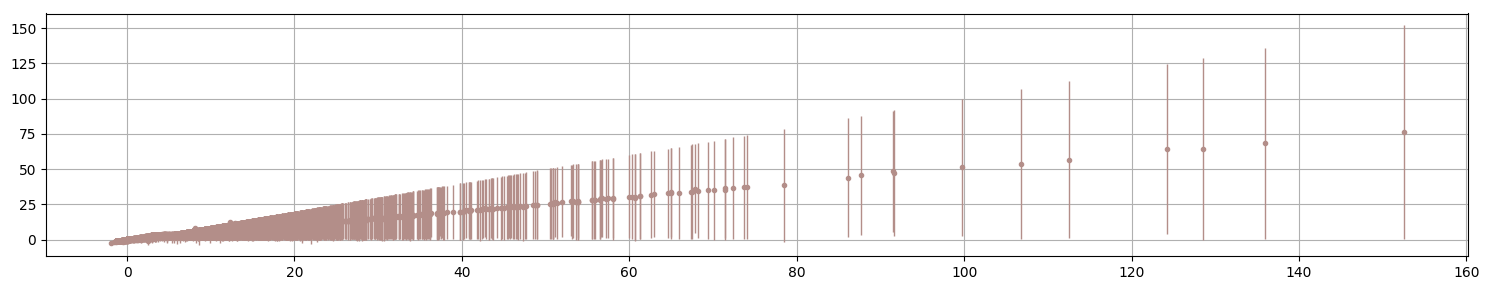

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
#plt.rcdefaults()

diffValsSquared = (np.asarray(trueVals_old) - np.asarray(predictedVals_old)) ** 2
diffVals = [math.sqrt(number) for number in diffValsSquared]

# First illustrate basic pyplot interface, using defaults where possible.
plt.errorbar(trueVals_old, predictedVals_old, yerr=diffVals, fmt='.', elinewidth=1, color='#B38E89')
plt.grid(True)
plt.tight_layout()
plt.rcParams["figure.figsize"] = (15,3)

plt.savefig('error_selection_rnn.png')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots()
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

dt = 0.01
t = np.arange(0, 30, dt)

# Fixing random state for reproducibility
np.random.seed(19680801)


nse1 = np.random.randn(len(t))                 # white noise 1
nse2 = np.random.randn(len(t))                 # white noise 2
r = np.exp(-t / 0.05)

cnse1 = np.convolve(nse1, r, mode='same') * dt   # colored noise 1
cnse2 = np.convolve(nse2, r, mode='same') * dt   # colored noise 2

# two signals with a coherent part and a random part
s1 = 0.01 * np.sin(2 * np.pi * 10 * t) + cnse1
s2 = 0.01 * np.sin(2 * np.pi * 10 * t) + cnse2

ax1.plot(t, s1, t, s2)
ax1.set_xlim(0, 5)
ax1.set_xlabel('time')
ax1.set_ylabel('s1 and s2')
ax1.grid(True)

cxy, f = ax2.csd(s1, s2, 256, 1. / dt)
ax2.set_ylabel('CSD (db)')
plt.show()

In [16]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results3/rnn/results_{}.csv".format(str(key)))

    with open("results3/rnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results_old)

Text(0, 0.5, 'Estimated surf_temp_sqerror')

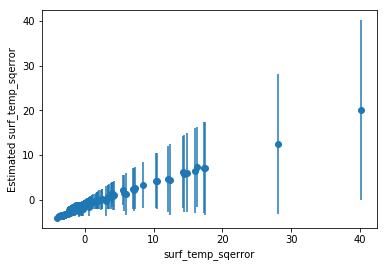

In [27]:
import math

diffValsSquared = (np.asarray(trueVals_old) - np.asarray(predictedVals_old)) ** 2
diffVals = [math.sqrt(number) for number in diffValsSquared]

plt.errorbar(trueVals_old, predictedVals_old, yerr=diffVals, fmt='o')
plt.xlabel('surf_temp_sqerror')
plt.ylabel('Estimated surf_temp_sqerror')

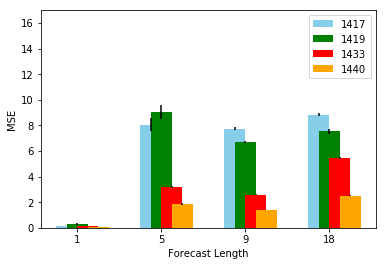

In [6]:
def loader():
    """Reading data from keys"""
    with open("results/rnn/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("results/rnn/data_{}.csv".format(str(key)))

    return dictex

results = loader()
graph_data = dict()
std_data = dict()
keys = [1417, 1419, 1433, 1440]

for key in keys:
    d = []
    st = []
    for i in [1, 5, 9, 18]:
        t = sum(results[(key, i)].values) / float(len(results[(key, i)]))
        s = np.std(results[(key, i)])[1]
        d.append(t[1])
        st.append(s)
    graph_data[key] = d
    std_data[key] = st

# Data for plotting
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ind = np.arange(len(graph_data[(1417)]))  # the x locations for the groups
width = 0.25  # the width of the bars

means, std = np.around(graph_data[1417], decimals=3), np.around(std_data[1417], decimals=3)
ax.bar(ind - width/2, means, width, yerr=std,
            color='SkyBlue', label=1417, align='center')

means, std = np.around(graph_data[1419], decimals=3), np.around(std_data[1419], decimals=3)
ax.bar(ind, means, width, yerr=std,
            color='Green', label=1419, align='center')

means, std = np.around(graph_data[1433], decimals=3), np.around(std_data[1433], decimals=3)
ax.bar(ind + width/2, means, width, yerr=std,
            color='Red', label=1433, align='center')

means, std = np.around(graph_data[1440], decimals=3), np.around(std_data[1440], decimals=3)
ax.bar(ind + width/2 + width/2, means, width, yerr=std,
            color='Orange', label=1440, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_xlabel('Forecast Length')
ax.set_xticks(ind)
ax.set_xticklabels((1, 5, 9, 18))
ax.set_ylim([0, 17])
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


#autolabel(rects1, "left")
#autolabel(rects2, "right")

plt.show()

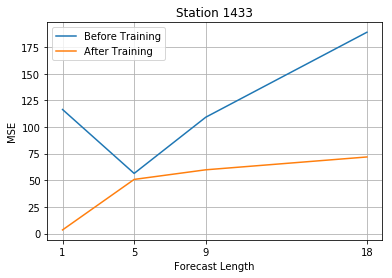

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

result_old_means = dict()
result_means = dict()

for key in results_old:
    result_old_means[key] = np.mean(results_old[key])
    result_means[key] = np.mean(results[key])

fig, ax = plt.subplots()

# Data for plotting
o = [result_old_means[(1433, 1)], result_old_means[(1433, 5)], result_old_means[(1433, 9)], result_old_means[(1433, 18)], ]
b = [1, 5, 9, 18]

ax.plot(b, o, label='Before Training')

# Data for plotting
t = [result_means[(1433, 1)], result_means[(1433, 5)], result_means[(1433, 9)], result_means[(1433, 18)], ]
s = [1, 5, 9, 18]

ax.plot(s, t, label='After Training')

ax.set(xlabel='Forecast Length', ylabel='MSE',
       title='Station 1433')
ax.grid()
ax.legend()
plt.xticks([1, 5, 9, 18])

fig.savefig("mse_improvement_knn_1433.png")
plt.show()

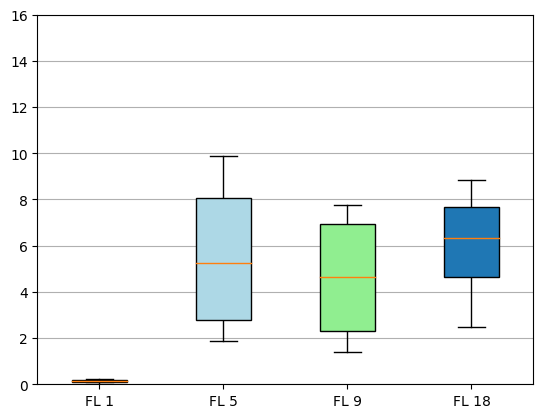

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
plt.rcdefaults()


def result_loader():
    """Reading data from keys"""
    with open("results/rnn/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("results/rnn/data_{}.csv".format(str(key)))

    return dictex

results = result_loader()

all_data = dict()
# Random test data
for key in [1417, 1419, 1433, 1440]:
    for fl in [1, 5, 9, 18]:
        if fl not in all_data.keys():
            all_data[fl] = []
        all_data[fl].append(results[(key, fl)].values[0][1])
    labels = ['FL 1', 'FL 5', 'FL 9', 'FL 18']

all_data = list(all_data.values())
fig, axes = plt.subplots()

# rectangular box plot
bplot1 = axes.boxplot(all_data, 0, '',
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_ylim([0, 16])

plt.savefig('mse_box_plot_rnn.png'.format(str(key)))
plt.show()